In [77]:
import torch 
from torch import nn 
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
from torch.optim import Adam 

import matplotlib.pyplot as plt 
from tqdm import tqdm

In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [79]:
device

'cuda'

In [80]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [81]:
data = datasets.MNIST('.', train=True, download=True, transform=train_transform)

train_data, val_data = random_split(data, [0.8, 0.2])
test_data = datasets.MNIST('.', train=False, download=True, transform=test_transform)

In [82]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, _ = self.data[idx]
        return x, x

In [83]:
train_data = CustomDataset(train_data)
val_data = CustomDataset(val_data)
test_data = CustomDataset(test_data)

In [84]:
def output(data, limit):
    for i, (x, y) in enumerate(data):
        x = x.permute(1, 2, 0).detach().cpu().numpy()
        y = y.permute(1, 2, 0).detach().cpu().numpy()
    
        plt.figure(figsize=(10, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(x)
        plt.title("Feature")
    
        plt.subplot(1, 2, 2)
        plt.imshow(y)
        plt.title("Label")
    
        plt.show()
    
        
        if i+1 >= limit:
            break
    

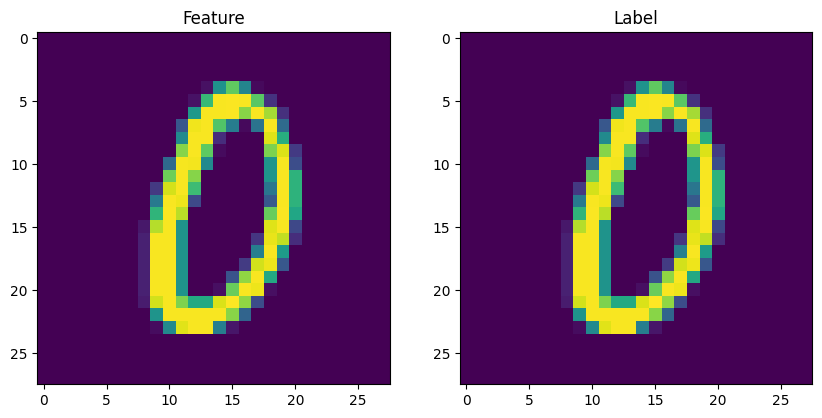

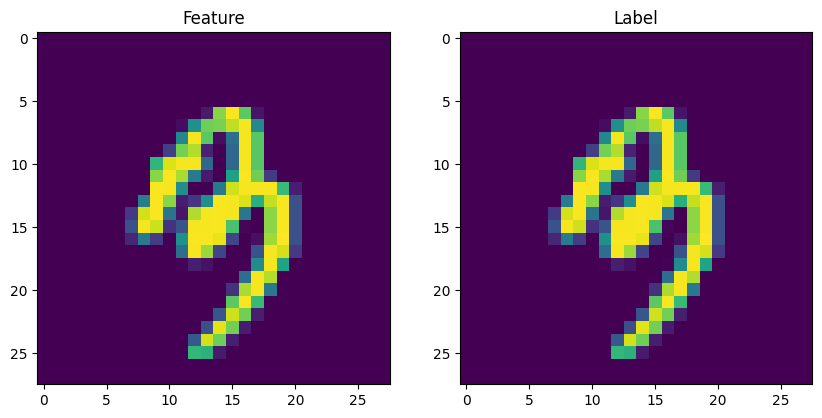

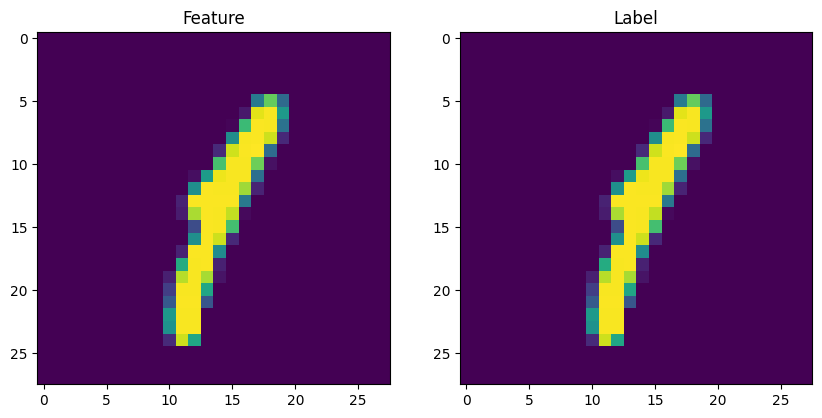

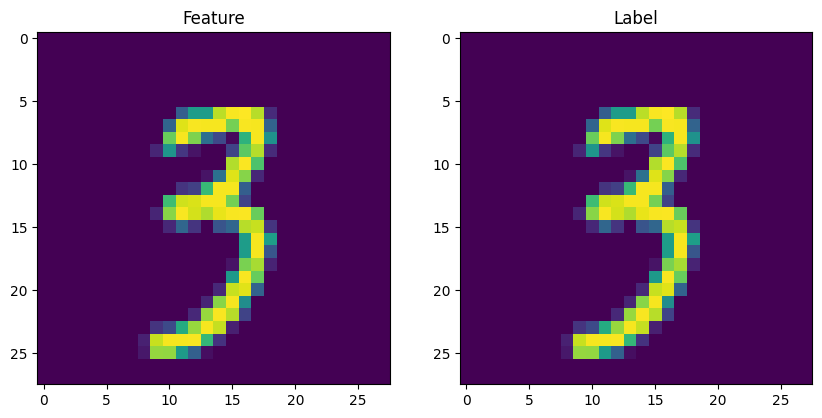

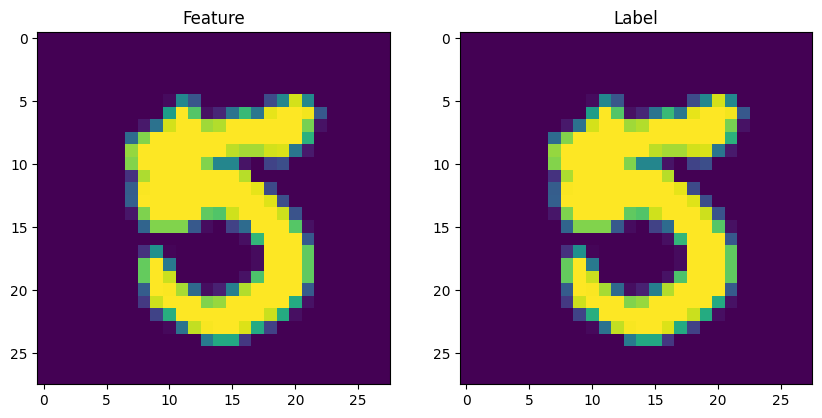

In [85]:
output(train_data, 5)

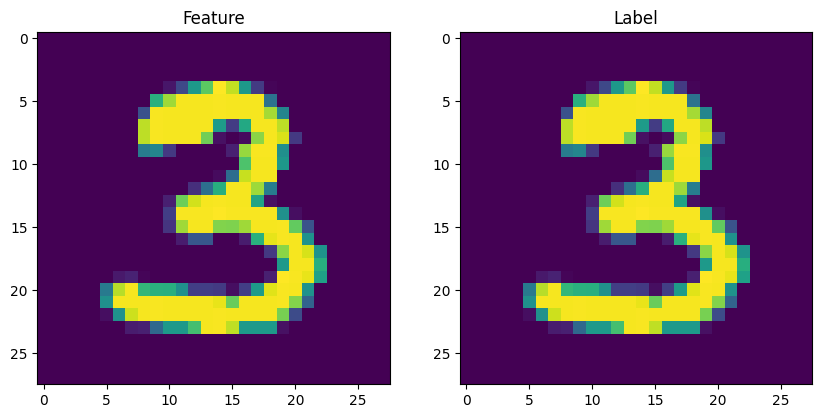

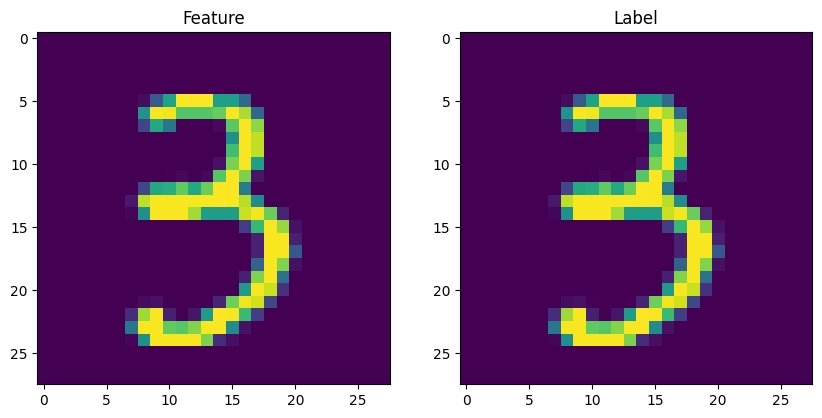

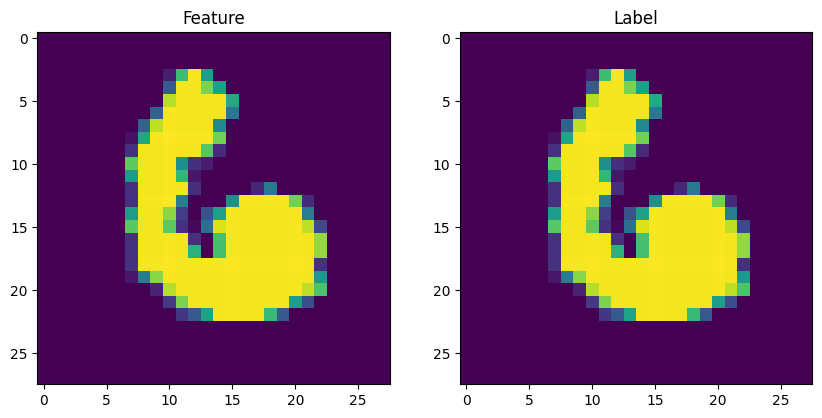

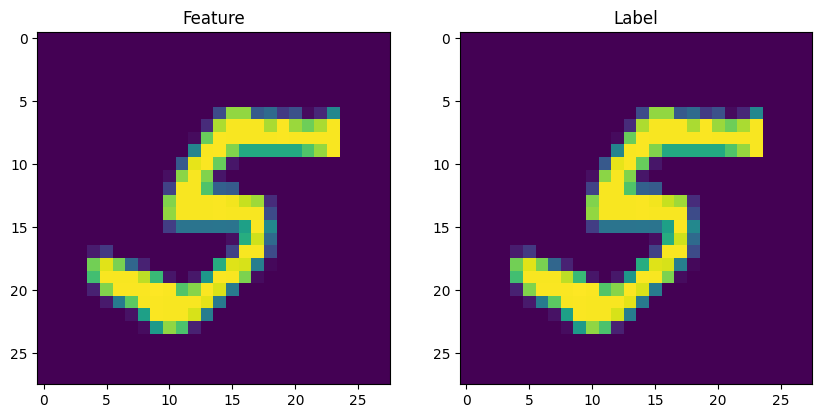

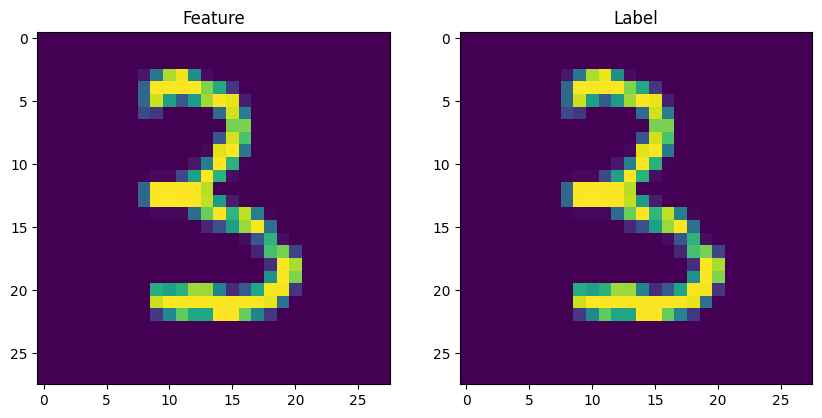

In [86]:
output(val_data, 5)

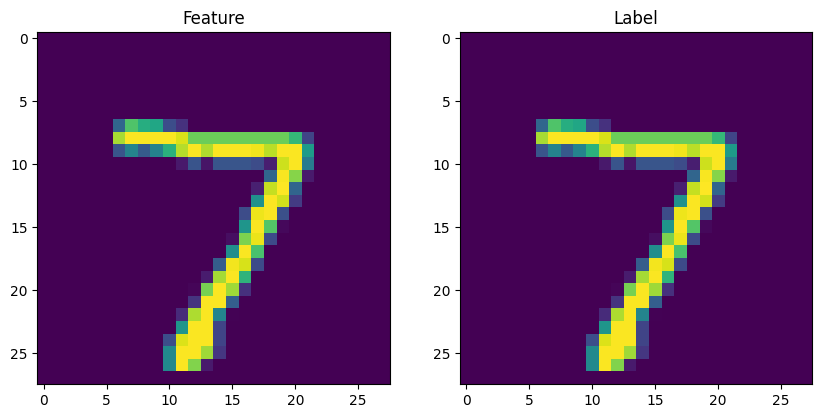

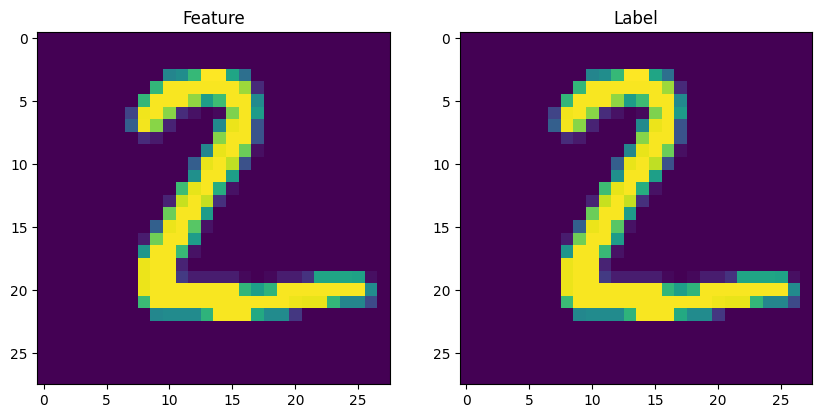

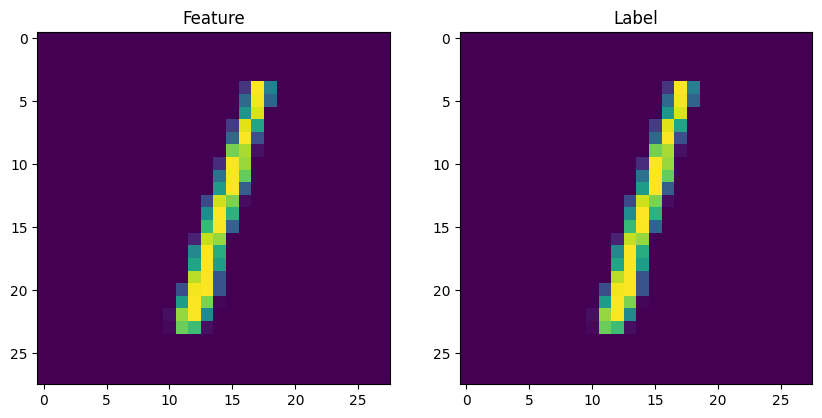

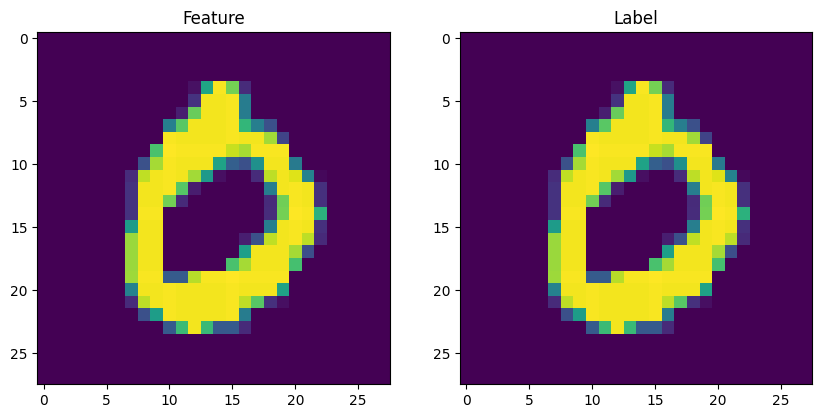

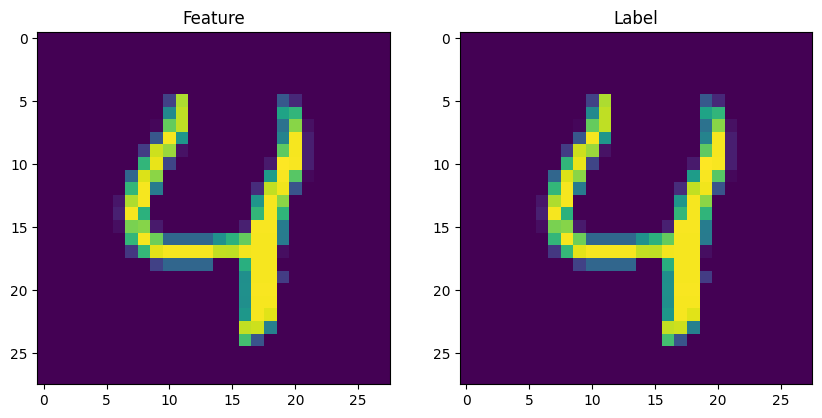

In [87]:
output(test_data, 5)

In [88]:
batch_size = 32

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=True)
train_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [89]:
x, y = next(iter(train_dl))
print(x.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28])


In [90]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        self.linear1 = nn.Linear(784, 400)
        self.linear2_mu = nn.Linear(400, latent_dim)
        self.linear2_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        mu = self.linear2_mu(h)
        logvar = self.linear2_logvar(h)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        self.linear1 = nn.Linear(latent_dim, 400)
        self.linear2 = nn.Linear(400, 784)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        rec = F.sigmoid(self.linear2(h))
        return rec


class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)


    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        # z = μ+σ*ε
        z = mu + std * eps
        return z

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        rec = self.decoder(z)
        return rec, mu, logvar

    def predict(self, x):
        self.eval()

        with torch.no_grad():
            x = x.view(-1, 784)
            out, _, _ = self.forward(x)
            out = out.view(-1, 28, 28)
            
        return out
            

In [91]:
def loss_function(rec, x, mu, logvar):
    x = x.view(-1, 784)
    BCE = nn.BCELoss(reduction='sum')
    BCE_loss = BCE(rec, x)
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE_loss + KL_divergence

In [92]:
model = VAE()
model.to(device)


VAE(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=400, bias=True)
    (linear2_mu): Linear(in_features=400, out_features=2, bias=True)
    (linear2_logvar): Linear(in_features=400, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=400, bias=True)
    (linear2): Linear(in_features=400, out_features=784, bias=True)
  )
)

In [93]:
tensor = torch.rand(1, 28, 28).to(device)
res, _, _ = model(tensor)
res.shape

torch.Size([1, 784])

Text(0.5, 1.0, 'Output')

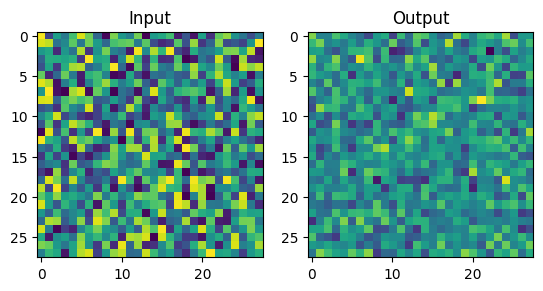

In [94]:
tensor = torch.rand(1, 28, 28).to(device)
t_tensor = tensor.permute(1, 2, 0).cpu().numpy()

res = model.predict(tensor)
res = res.permute(1, 2, 0).cpu().numpy()

plt.subplot(1, 2, 1)
plt.imshow(t_tensor)
plt.title("Input")

plt.subplot(1, 2, 2)
plt.imshow(res)
plt.title("Output")

In [95]:
optimizer = Adam(model.parameters(), lr=1e-3)

In [96]:
def train(model, train_dl, val_dl, loss_fn, optimizer, epochs, device):
    history = {
        "train_loss": [],
        "val_loss": []
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            pred, mu, log_var = model(x)
            
            loss = loss_fn(pred, y, mu, log_var)
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        total_train_loss = train_loss / len(train_dl)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)
                
                pred, mu, log_var = model(x)
                loss = loss_fn(pred, y, mu, log_var)
                val_loss += loss.item()


        total_val_loss = val_loss / len(val_dl)

        history["train_loss"].append(total_train_loss)
        history["val_loss"].append(total_val_loss)

        print(
            f"Epoch: {epoch+1}; "
            f"train_loss: {total_train_loss:.4f}; "
            f"val_loss: {total_val_loss:.4f}"
        )

    return history           
        

In [97]:
history = train(model, train_dl, val_dl, loss_function, optimizer, 100, device)

100%|██████████| 375/375 [00:01<00:00, 251.79it/s]


Epoch: 1; train_loss: 6239.0884; val_loss: 5798.7368


100%|██████████| 375/375 [00:01<00:00, 252.18it/s]


Epoch: 2; train_loss: 5490.7498; val_loss: 5556.4357


100%|██████████| 375/375 [00:01<00:00, 251.96it/s]


Epoch: 3; train_loss: 5349.3499; val_loss: 5455.9653


100%|██████████| 375/375 [00:01<00:00, 244.85it/s]


Epoch: 4; train_loss: 5272.2866; val_loss: 5430.9133


100%|██████████| 375/375 [00:01<00:00, 252.26it/s]


Epoch: 5; train_loss: 5220.8364; val_loss: 5367.7135


100%|██████████| 375/375 [00:01<00:00, 251.64it/s]


Epoch: 6; train_loss: 5171.2008; val_loss: 5325.7551


100%|██████████| 375/375 [00:01<00:00, 252.76it/s]


Epoch: 7; train_loss: 5136.8519; val_loss: 5344.9487


100%|██████████| 375/375 [00:01<00:00, 252.77it/s]


Epoch: 8; train_loss: 5101.5394; val_loss: 5295.7415


100%|██████████| 375/375 [00:01<00:00, 252.87it/s]


Epoch: 9; train_loss: 5070.0277; val_loss: 5265.3478


100%|██████████| 375/375 [00:01<00:00, 252.39it/s]


Epoch: 10; train_loss: 5046.9281; val_loss: 5256.6727


100%|██████████| 375/375 [00:01<00:00, 254.62it/s]


Epoch: 11; train_loss: 5021.4094; val_loss: 5222.9335


100%|██████████| 375/375 [00:01<00:00, 252.35it/s]


Epoch: 12; train_loss: 4998.7355; val_loss: 5201.0099


100%|██████████| 375/375 [00:01<00:00, 253.67it/s]


Epoch: 13; train_loss: 4981.4863; val_loss: 5199.0385


100%|██████████| 375/375 [00:01<00:00, 242.09it/s]


Epoch: 14; train_loss: 4962.9917; val_loss: 5176.1980


100%|██████████| 375/375 [00:01<00:00, 248.61it/s]


Epoch: 15; train_loss: 4944.7129; val_loss: 5167.6998


100%|██████████| 375/375 [00:01<00:00, 253.03it/s]


Epoch: 16; train_loss: 4931.0607; val_loss: 5173.6089


100%|██████████| 375/375 [00:01<00:00, 252.98it/s]


Epoch: 17; train_loss: 4913.0524; val_loss: 5176.1404


100%|██████████| 375/375 [00:01<00:00, 247.02it/s]


Epoch: 18; train_loss: 4903.7949; val_loss: 5148.5331


100%|██████████| 375/375 [00:01<00:00, 253.44it/s]


Epoch: 19; train_loss: 4887.5645; val_loss: 5146.1540


100%|██████████| 375/375 [00:01<00:00, 250.03it/s]


Epoch: 20; train_loss: 4876.7189; val_loss: 5125.8495


100%|██████████| 375/375 [00:01<00:00, 242.79it/s]


Epoch: 21; train_loss: 4868.1430; val_loss: 5138.9557


100%|██████████| 375/375 [00:01<00:00, 251.38it/s]


Epoch: 22; train_loss: 4854.9278; val_loss: 5126.4140


100%|██████████| 375/375 [00:01<00:00, 250.69it/s]


Epoch: 23; train_loss: 4845.9677; val_loss: 5148.7089


100%|██████████| 375/375 [00:01<00:00, 231.48it/s]


Epoch: 24; train_loss: 4836.3858; val_loss: 5135.9564


100%|██████████| 375/375 [00:01<00:00, 253.32it/s]


Epoch: 25; train_loss: 4828.4566; val_loss: 5128.0894


100%|██████████| 375/375 [00:01<00:00, 253.71it/s]


Epoch: 26; train_loss: 4820.7680; val_loss: 5120.0517


100%|██████████| 375/375 [00:01<00:00, 247.32it/s]


Epoch: 27; train_loss: 4812.1841; val_loss: 5115.1036


100%|██████████| 375/375 [00:01<00:00, 252.68it/s]


Epoch: 28; train_loss: 4802.4543; val_loss: 5114.6612


100%|██████████| 375/375 [00:01<00:00, 252.74it/s]


Epoch: 29; train_loss: 4798.0982; val_loss: 5099.5515


100%|██████████| 375/375 [00:01<00:00, 248.66it/s]


Epoch: 30; train_loss: 4792.4367; val_loss: 5104.5910


100%|██████████| 375/375 [00:01<00:00, 255.94it/s]


Epoch: 31; train_loss: 4782.7760; val_loss: 5097.3180


100%|██████████| 375/375 [00:01<00:00, 255.74it/s]


Epoch: 32; train_loss: 4777.7061; val_loss: 5099.8859


100%|██████████| 375/375 [00:01<00:00, 252.71it/s]


Epoch: 33; train_loss: 4771.4981; val_loss: 5090.8539


100%|██████████| 375/375 [00:01<00:00, 241.76it/s]


Epoch: 34; train_loss: 4763.8049; val_loss: 5102.9417


100%|██████████| 375/375 [00:01<00:00, 254.51it/s]


Epoch: 35; train_loss: 4762.1441; val_loss: 5096.6903


100%|██████████| 375/375 [00:01<00:00, 253.41it/s]


Epoch: 36; train_loss: 4757.6505; val_loss: 5102.5098


100%|██████████| 375/375 [00:01<00:00, 252.44it/s]


Epoch: 37; train_loss: 4757.9973; val_loss: 5094.1466


100%|██████████| 375/375 [00:01<00:00, 251.93it/s]


Epoch: 38; train_loss: 4754.4597; val_loss: 5119.1856


100%|██████████| 375/375 [00:01<00:00, 251.19it/s]


Epoch: 39; train_loss: 4746.2262; val_loss: 5119.3323


100%|██████████| 375/375 [00:01<00:00, 250.25it/s]


Epoch: 40; train_loss: 4749.9612; val_loss: 5115.3684


100%|██████████| 375/375 [00:01<00:00, 251.08it/s]


Epoch: 41; train_loss: 4737.4887; val_loss: 5128.0964


100%|██████████| 375/375 [00:01<00:00, 251.03it/s]


Epoch: 42; train_loss: 4729.9496; val_loss: 5100.4009


100%|██████████| 375/375 [00:01<00:00, 250.73it/s]


Epoch: 43; train_loss: 4722.4913; val_loss: 5094.3870


100%|██████████| 375/375 [00:01<00:00, 250.74it/s]


Epoch: 44; train_loss: 4720.9699; val_loss: 5091.6956


100%|██████████| 375/375 [00:01<00:00, 254.39it/s]


Epoch: 45; train_loss: 4717.1986; val_loss: 5090.3710


100%|██████████| 375/375 [00:01<00:00, 250.84it/s]


Epoch: 46; train_loss: 4709.9070; val_loss: 5109.5415


100%|██████████| 375/375 [00:01<00:00, 248.76it/s]


Epoch: 47; train_loss: 4706.4546; val_loss: 5102.4508


100%|██████████| 375/375 [00:01<00:00, 246.85it/s]


Epoch: 48; train_loss: 4701.8615; val_loss: 5123.3487


100%|██████████| 375/375 [00:01<00:00, 250.64it/s]


Epoch: 49; train_loss: 4701.7894; val_loss: 5127.4882


100%|██████████| 375/375 [00:01<00:00, 253.83it/s]


Epoch: 50; train_loss: 4692.2029; val_loss: 5100.2347


100%|██████████| 375/375 [00:01<00:00, 253.75it/s]


Epoch: 51; train_loss: 4693.6555; val_loss: 5134.5991


100%|██████████| 375/375 [00:01<00:00, 248.48it/s]


Epoch: 52; train_loss: 4695.2482; val_loss: 5134.8451


100%|██████████| 375/375 [00:01<00:00, 250.89it/s]


Epoch: 53; train_loss: 4687.6900; val_loss: 5091.6020


100%|██████████| 375/375 [00:01<00:00, 252.07it/s]


Epoch: 54; train_loss: 4680.6645; val_loss: 5110.8673


100%|██████████| 375/375 [00:01<00:00, 247.23it/s]


Epoch: 55; train_loss: 4674.8592; val_loss: 5104.3740


100%|██████████| 375/375 [00:01<00:00, 250.98it/s]


Epoch: 56; train_loss: 4669.5608; val_loss: 5119.7909


100%|██████████| 375/375 [00:01<00:00, 252.36it/s]


Epoch: 57; train_loss: 4668.4526; val_loss: 5109.3137


100%|██████████| 375/375 [00:01<00:00, 248.44it/s]


Epoch: 58; train_loss: 4671.0898; val_loss: 5130.0554


100%|██████████| 375/375 [00:01<00:00, 252.76it/s]


Epoch: 59; train_loss: 4669.6574; val_loss: 5112.5841


100%|██████████| 375/375 [00:01<00:00, 252.85it/s]


Epoch: 60; train_loss: 4660.5056; val_loss: 5107.4827


100%|██████████| 375/375 [00:01<00:00, 248.87it/s]


Epoch: 61; train_loss: 4658.8880; val_loss: 5109.7453


100%|██████████| 375/375 [00:01<00:00, 254.42it/s]


Epoch: 62; train_loss: 4656.7568; val_loss: 5115.8304


100%|██████████| 375/375 [00:01<00:00, 252.83it/s]


Epoch: 63; train_loss: 4651.7471; val_loss: 5105.3673


100%|██████████| 375/375 [00:01<00:00, 250.73it/s]


Epoch: 64; train_loss: 4650.2531; val_loss: 5118.4951


100%|██████████| 375/375 [00:01<00:00, 250.22it/s]


Epoch: 65; train_loss: 4646.0887; val_loss: 5103.1880


100%|██████████| 375/375 [00:01<00:00, 252.22it/s]


Epoch: 66; train_loss: 4641.4492; val_loss: 5098.8076


100%|██████████| 375/375 [00:01<00:00, 249.70it/s]


Epoch: 67; train_loss: 4637.0073; val_loss: 5109.1295


100%|██████████| 375/375 [00:01<00:00, 252.21it/s]


Epoch: 68; train_loss: 4635.4590; val_loss: 5116.1435


100%|██████████| 375/375 [00:01<00:00, 249.26it/s]


Epoch: 69; train_loss: 4637.2300; val_loss: 5110.3107


100%|██████████| 375/375 [00:01<00:00, 247.23it/s]


Epoch: 70; train_loss: 4638.3515; val_loss: 5088.3818


100%|██████████| 375/375 [00:01<00:00, 248.42it/s]


Epoch: 71; train_loss: 4633.3341; val_loss: 5098.3157


100%|██████████| 375/375 [00:01<00:00, 249.36it/s]


Epoch: 72; train_loss: 4628.8658; val_loss: 5114.7078


100%|██████████| 375/375 [00:01<00:00, 235.34it/s]


Epoch: 73; train_loss: 4623.3459; val_loss: 5120.6140


100%|██████████| 375/375 [00:01<00:00, 253.26it/s]


Epoch: 74; train_loss: 4622.9966; val_loss: 5108.7041


100%|██████████| 375/375 [00:01<00:00, 243.55it/s]


Epoch: 75; train_loss: 4620.4441; val_loss: 5116.6708


100%|██████████| 375/375 [00:01<00:00, 254.29it/s]


Epoch: 76; train_loss: 4618.1298; val_loss: 5124.2652


100%|██████████| 375/375 [00:01<00:00, 248.11it/s]


Epoch: 77; train_loss: 4620.8313; val_loss: 5145.5813


100%|██████████| 375/375 [00:01<00:00, 252.72it/s]


Epoch: 78; train_loss: 4619.4739; val_loss: 5137.1390


100%|██████████| 375/375 [00:01<00:00, 249.65it/s]


Epoch: 79; train_loss: 4612.9643; val_loss: 5109.3848


100%|██████████| 375/375 [00:01<00:00, 254.70it/s]


Epoch: 80; train_loss: 4610.1679; val_loss: 5127.5606


100%|██████████| 375/375 [00:01<00:00, 252.29it/s]


Epoch: 81; train_loss: 4613.9550; val_loss: 5126.5755


100%|██████████| 375/375 [00:01<00:00, 254.67it/s]


Epoch: 82; train_loss: 4612.3893; val_loss: 5142.4570


100%|██████████| 375/375 [00:01<00:00, 231.42it/s]


Epoch: 83; train_loss: 4606.9282; val_loss: 5147.6677


100%|██████████| 375/375 [00:01<00:00, 254.84it/s]


Epoch: 84; train_loss: 4603.7071; val_loss: 5135.7845


100%|██████████| 375/375 [00:01<00:00, 252.04it/s]


Epoch: 85; train_loss: 4607.6417; val_loss: 5197.5151


100%|██████████| 375/375 [00:01<00:00, 250.91it/s]


Epoch: 86; train_loss: 4602.8999; val_loss: 5138.5922


100%|██████████| 375/375 [00:01<00:00, 253.10it/s]


Epoch: 87; train_loss: 4597.8806; val_loss: 5131.0633


100%|██████████| 375/375 [00:01<00:00, 255.79it/s]


Epoch: 88; train_loss: 4596.6031; val_loss: 5151.3558


100%|██████████| 375/375 [00:01<00:00, 246.83it/s]


Epoch: 89; train_loss: 4598.1728; val_loss: 5156.5021


100%|██████████| 375/375 [00:01<00:00, 254.00it/s]


Epoch: 90; train_loss: 4593.5306; val_loss: 5122.4193


100%|██████████| 375/375 [00:01<00:00, 254.63it/s]


Epoch: 91; train_loss: 4589.1042; val_loss: 5130.6599


100%|██████████| 375/375 [00:01<00:00, 249.70it/s]


Epoch: 92; train_loss: 4589.5732; val_loss: 5143.1169


100%|██████████| 375/375 [00:01<00:00, 237.37it/s]


Epoch: 93; train_loss: 4587.4469; val_loss: 5120.2829


100%|██████████| 375/375 [00:01<00:00, 253.29it/s]


Epoch: 94; train_loss: 4583.8829; val_loss: 5142.5495


100%|██████████| 375/375 [00:01<00:00, 252.99it/s]


Epoch: 95; train_loss: 4583.7417; val_loss: 5151.1278


100%|██████████| 375/375 [00:01<00:00, 249.54it/s]


Epoch: 96; train_loss: 4583.9945; val_loss: 5144.8142


100%|██████████| 375/375 [00:01<00:00, 252.81it/s]


Epoch: 97; train_loss: 4581.4942; val_loss: 5138.5184


100%|██████████| 375/375 [00:01<00:00, 254.28it/s]


Epoch: 98; train_loss: 4577.2951; val_loss: 5149.0340


100%|██████████| 375/375 [00:01<00:00, 255.34it/s]


Epoch: 99; train_loss: 4577.0439; val_loss: 5169.9066


100%|██████████| 375/375 [00:01<00:00, 253.96it/s]

Epoch: 100; train_loss: 4575.7029; val_loss: 5158.8989


In [98]:
def output_results(data, limit):
    for i, (img, _) in enumerate(data):
        img = img.to(device)
        t_img = img.permute(1, 2, 0).cpu().numpy()
        
        plt.subplot(1, 2, 1)
        plt.imshow(t_img)
        plt.title("Original")
        
        res = model.predict(img)
        res = res.permute(1, 2, 0).cpu().numpy()
        plt.subplot(1, 2, 2)
        plt.imshow(res)
        plt.title("Generated")
    
        plt.show()
    
        if i+1 >= limit:
            break 




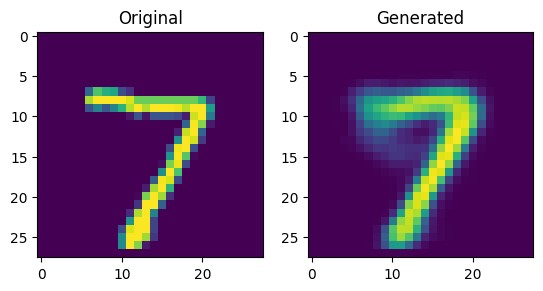

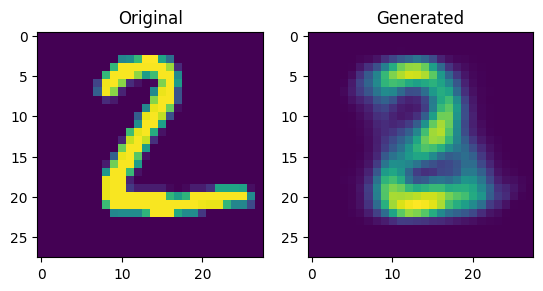

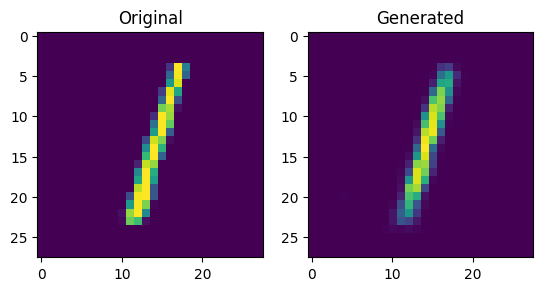

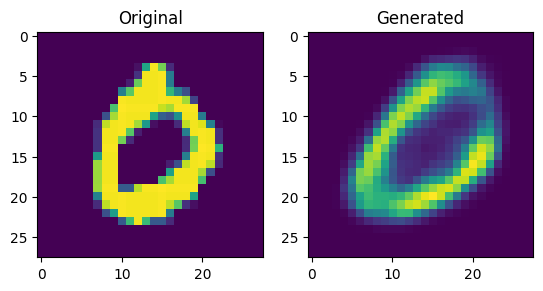

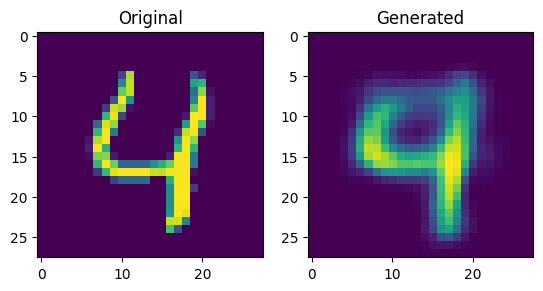

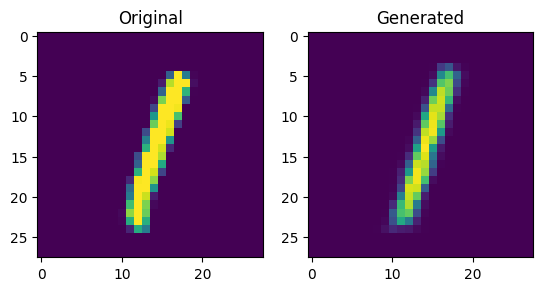

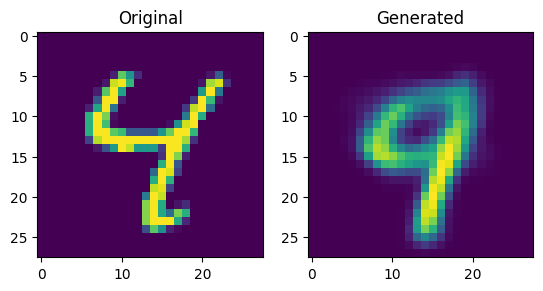

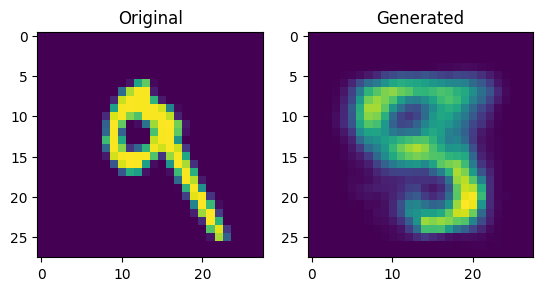

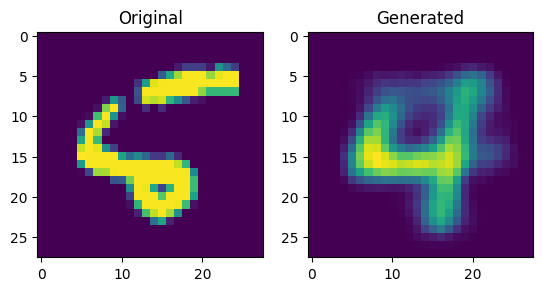

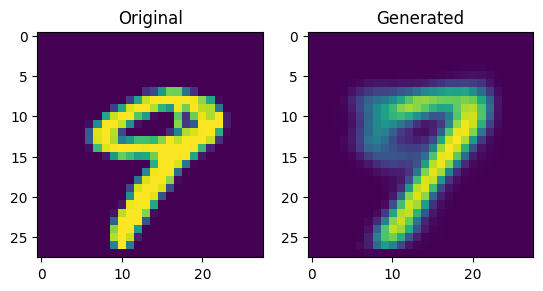

In [99]:
output_results(test_data, 10)